#David Barnett
#Predicting the Speed of Coronal Mass Ejections
#Data Exploration

I saved the data from the collection step to GitHub, so I'm going to read the data from there in this notebook and the machine learning notebook.

In [1]:
import pandas as pd
import numpy as np

data_dir = ("https://raw.githubusercontent.com/DavidBarnett0/" + 
            "data301_project/master/")

cme_df = pd.read_csv(data_dir + "cme.csv", 
                     index_col="startTime", 
                     parse_dates = True)

analysis_df = pd.read_csv(data_dir + "cmeanalysis.csv", 
                          index_col="occurrence_time",
                          parse_dates = True)

cme_df["note"][cme_df["note"].isna()] = ""
analysis_df["note"][analysis_df["note"].isna()] = ""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [2]:
cme_df.head()

,activeRegionNum,instruments,linkedEvents,note,N/S,E/W
startTime,,,,,,
2015-01-01 08:24:00,NaN,SOHO: LASCO/C2 SOHO: LASCO/C3,0,"Eruption visible in SDO 193, starting ~ 2014-1...",NaN,NaN
2015-01-02 14:36:00,NaN,SOHO: LASCO/C2 SOHO: LASCO/C3,1,Associated with a very gradual eruption in a s...,-7.0,-40.0
2015-01-03 03:24:00,NaN,SOHO: LASCO/C2 SOHO: LASCO/C3,0,,NaN,NaN
2015-01-06 18:24:00,NaN,SOHO: LASCO/C2 SOHO: LASCO/C3,0,No source region could be found in SDO.,NaN,NaN
2015-01-07 16:24:00,NaN,SOHO: LASCO/C2 SOHO: LASCO/C3 STEREO A: SECCHI...,0,SDO 193 shows indication of an eruption off th...,NaN,NaN


In [3]:
analysis_df.head()

,latitude,longitude,halfAngle,speed,type,note,analysis_time,time_before_analysis,time_since_last_cme
occurrence_time,,,,,,,,,
2015-01-01 08:24:00,31.0,26.0,32.0,350.0,S,using both SWPC_cat and STEREO_cat with approx...,2015-01-01 23:14:00,14.833333,NaN
2015-01-02 14:36:00,3.0,34.0,23.0,353.0,S,Reanalyzed with more C2 and STEREOA imagery,2015-01-02 23:55:00,9.316667,30.2
2015-01-03 03:24:00,-49.0,-82.0,42.0,210.0,S,Source region could not be found. It's possibl...,2015-01-03 23:40:00,20.266667,12.8
2015-01-06 18:24:00,9.0,39.0,12.0,532.0,C,,2015-01-07 00:25:00,6.016667,87.0
2015-01-07 16:24:00,67.0,-102.0,20.0,579.0,C,,2015-01-08 03:10:00,10.766667,22.0


First I'm going to look to see if there are any glaring correlations within each dataset.

In [4]:
display(cme_df.corr())
display(analysis_df.corr())

,activeRegionNum,linkedEvents,N/S,E/W
activeRegionNum,1.000000,0.019043,0.145058,0.032607
linkedEvents,0.019043,1.000000,-0.105854,-0.006043
N/S,0.145058,-0.105854,1.000000,0.057252
E/W,0.032607,-0.006043,0.057252,1.000000


,latitude,longitude,halfAngle,speed,time_before_analysis,time_since_last_cme
latitude,1.000000,-0.020221,-0.052143,0.011719,-0.001737,-0.072090
longitude,-0.020221,1.000000,-0.051281,-0.033419,0.068588,0.002897
halfAngle,-0.052143,-0.051281,1.000000,0.305805,-0.110537,-0.121278
speed,0.011719,-0.033419,0.305805,1.000000,-0.660064,-0.102764
time_before_analysis,-0.001737,0.068588,-0.110537,-0.660064,1.000000,0.068160
time_since_last_cme,-0.072090,0.002897,-0.121278,-0.102764,0.068160,1.000000


There appears to be a strong correlation between speed and time before analysis and a slight correlation between half angle and speed, but besides that there is not much correlation within the data frames.

I'm also going to compare the N/S and E/W variable against latitude and longitude because it seems like those variables might be the same.

In [5]:
indexes = cme_df[cme_df["N/S"].notna()].index

lat_df = cme_df.loc[indexes][["N/S"]].join(
    analysis_df.loc[indexes][["latitude"]]
)
lon_df = cme_df.loc[indexes][["E/W"]].join(
    analysis_df.loc[indexes][["longitude"]]
)

display(lat_df.corr())
display(lon_df.corr())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys


,N/S,latitude
N/S,1.000000,0.773248
latitude,0.773248,1.000000


,E/W,longitude
E/W,1.000000,-0.853627
longitude,-0.853627,1.000000


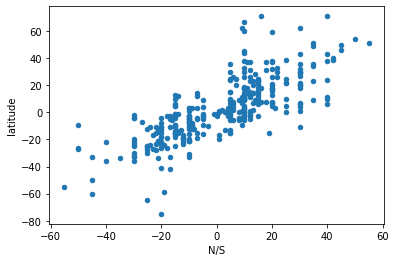

In [6]:
lat_df.plot.scatter(x = "N/S", y = "latitude")

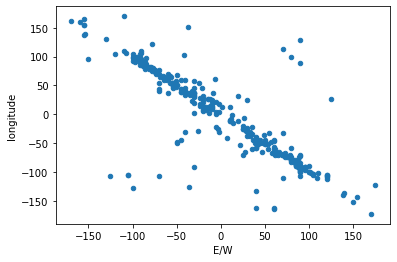

In [7]:
lon_df.plot.scatter(x = "E/W", y = "longitude")

Although these variables are highly correlated, they are not the same variable. I assume they measure different aspects of the CME, but rather than speculate, I'm just going to keep both in for now as unique location variables. Interestingly, the N/S variable had one value at 100 and one at 253, which do not fall between -90 and 90. I'm assuming these are mistakes, so I dropped those points in the data cleaning process.

It appears that the longitude in the analysis data frame may count western points as positive and eastern points as negative, but I'm not going to change either data frame because the cme data frame has the correct coordinate format and won't care if the sign in front of longitude is positive or negative when running machine learning analyses, as long as it remains consistent.


Now I'm going to make scatterplots of both location combinations

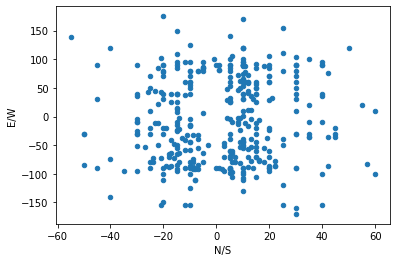

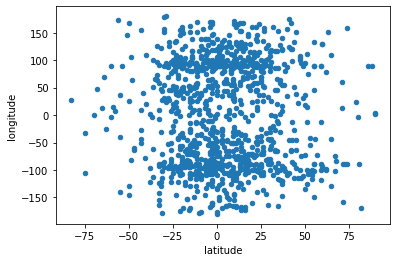

In [8]:
cme_df.plot.scatter(x = "N/S", y = "E/W")
analysis_df.plot.scatter(x = "latitude", y = "longitude")

Interestingly, there appear to be less variables near the center of both graphs. This implies that most CMEs occur around the edges of the Sun's latitude and longitude coordinate system, rather than near its center.

Now I'm going to perform some time series analyses. The variables to which I will apply this are:

-Speed

-Half Angle (effectively direction)

-Time before the CME analysis was performed

-Time since the last CME

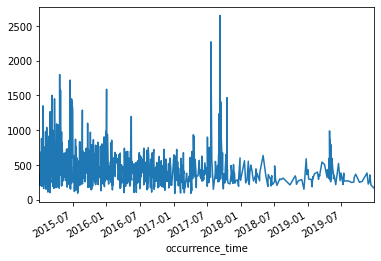

In [9]:
#Speed in km/s
analysis_df["speed"].plot.line()

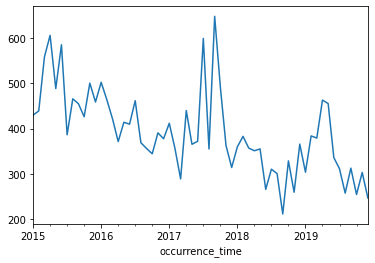

In [10]:
analysis_df.resample("1M")["speed"].mean().dropna().plot.line()

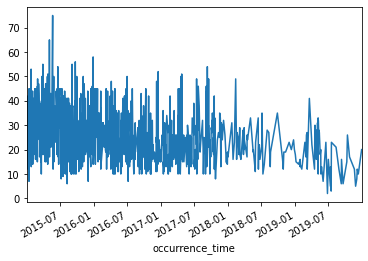

In [11]:
#Half Angle (direction)
analysis_df["halfAngle"].plot.line()

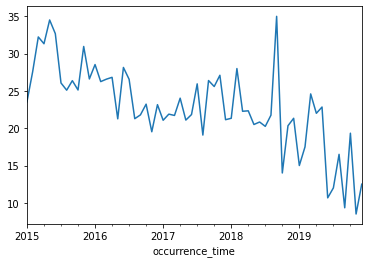

In [12]:
analysis_df.resample("1M")["halfAngle"].mean().plot.line()

It appears that speed and direction both decrease over time. These differences might affect how the machine learning portion of the project performs since the training and testing sets are based off of time, but these differences justify using the time-based training and testing set since the model is supposed to predict future speeds.

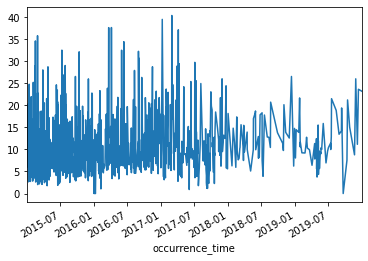

In [13]:
#Time until CME analysis was performed
analysis_df["time_before_analysis"].plot.line()

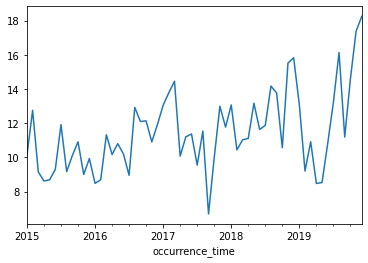

In [14]:
analysis_df.resample("1M")["time_before_analysis"].mean().plot.line()

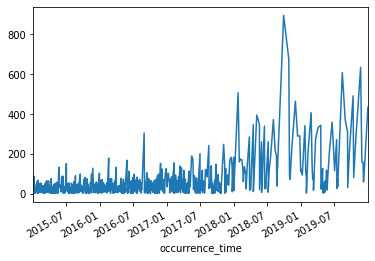

In [15]:
#Time since the last CME occurred
analysis_df["time_since_last_cme"].plot.line()

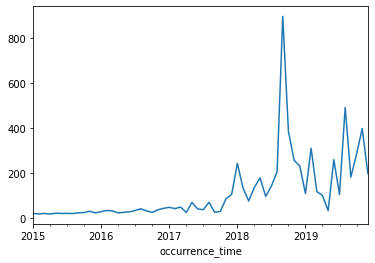

In [16]:
analysis_df.resample("1M")["time_since_last_cme"].mean().plot.line()

According to these plots, time since the last CME and time until analysis both increase, indicating that the overall number of CMEs has declined in more recent years.

Now I will make scatterplots of speed against the remaining variables from the above time series analyses.

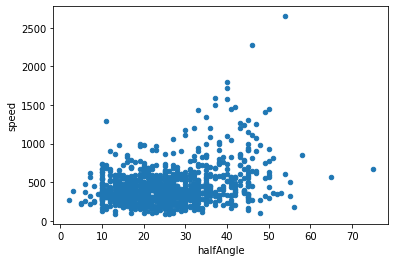

In [17]:
analysis_df.plot.scatter(x = "halfAngle", y = "speed")

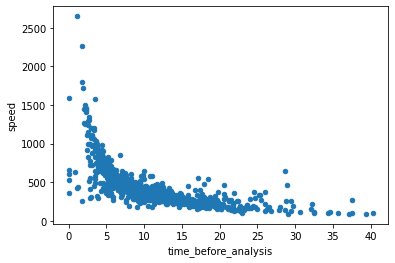

In [18]:
analysis_df.plot.scatter(x = "time_before_analysis", y = "speed")

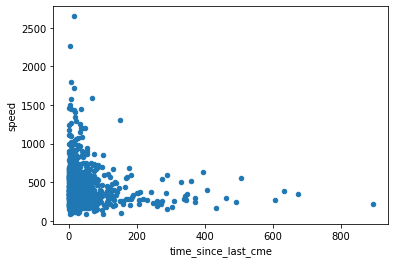

In [19]:
analysis_df.plot.scatter(x = "time_since_last_cme", y = "speed")

Time between the CME and the analysis has a strong exponential correlation with speed, meaning that faster CMEs likely caused the analyses to be performed quicker. Speed and half angle appear to have a correlation as well, as indicated by the previous correlation table

Now I will perform time series analyses on the active region number and whether or not there was a linked event associated with the CME, but I had to extend the resample range of these variables since there were very few observations that had either of these variables.

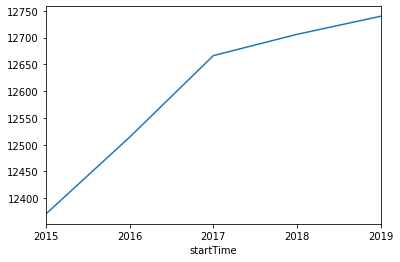

In [20]:
cme_df.resample("1Y")["activeRegionNum"].mean().plot.line()

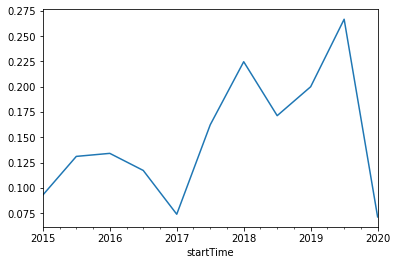

In [21]:
cme_df.resample("6M")["linkedEvents"].mean().plot.line()

The active region number appears to be shifting over time, showing a clear correlation with time. It appears that the number of linked events may also increase over time, but this is harder to tell since the last point on the plot is so low.

Finally I will make a boxplot of speed and the type of CME, which is the only nonbinary categorical variable in the dataset.

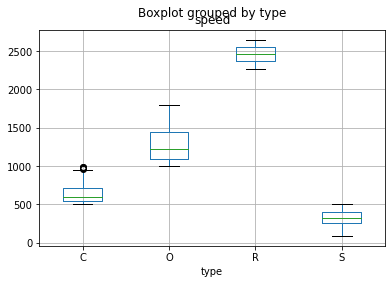

In [22]:
analysis_df.boxplot(by = "type", column = ["speed"])

The type of CME seems to heavily indicate its speed. Unfortunately, since the README for this dataset is inaccessible and I could not find anything resembling these values for CME type online, I do not know much about what each CME type means.